Fake News Classifier
=====================
представено от:
  1.  Име: Кирил Йотов <br>
      Факултетен номер: 7MI0800146<br>
      Специалност: КН, бакалавър <br>
      
  2.  Име: Христо Жаблянов<br>
      Факултетен номер: 82158<br>
      Специлност: КН, бакалавър<br>

Тип на проекта: 'А'

Проекта е базиран на kaggle [Fake News Classification](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification).

### Библиотеки
Библиотеките, които ще използваме, са от стандартните за курса:
- numpy
- pandas
- matplotlib
- scikit-learn
- seaborn

### Алгоритми:
- **Naive Bayes**: Базиран на условна вероятност, но предполага, че атирбутите са независими. Това го прави ефикасен, но може да не ни е много от помощ, ако създаваме нови колони, базирано на title/text.
- **Logistic Regression**: Базиран е на линейна регресия, която намира линейна функция на атрибутите. Но докато линейната регресия работи с непрекъснати стойности, логистичната е адаптирана за дискретни.
- **KNN**: Мързелив алгоритъм, който пази всички данни и predict-ва нови, като сравнява близостта им със старите.
- **Decision Tree**: Изгражда дърво, където листата са класове, вътрешните възли са тествани атирбути, а ребрата са възможни стойности на тестваните атрибути.
- **Random Forest**: Метод на ансамблово учене, където се тренират множество дървета и се ползва гласуване за predict-ване.

### Разглеждане на данните

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('./dataset/WELFake_Dataset.csv')
data.drop(data.columns[0], axis=1, inplace=True)

In [33]:
print(data.shape)
print()
print(data.info())
print()
print(data.describe())

(72134, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

              label
count  72134.000000
mean       0.514404
std        0.499796
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


Данните представляват 3 колони:
- title: заглавие на новината
- text: текст на новината
- label: бинарна стойност, която показва дали новината е фалшива или истинска
    - 0: Fake
    - 1: Real

In [34]:
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Данните са разпределени сравнително равномерно.

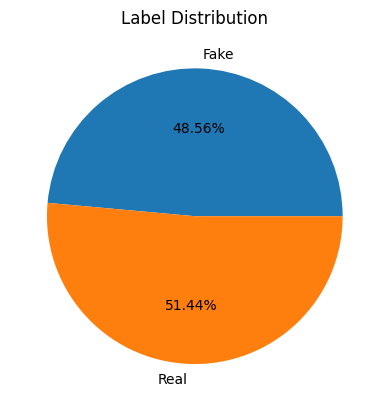

In [35]:
data.groupby('label').size().plot(kind = 'pie', autopct = '%.2f%%', labels = ['Fake', 'Real'])
plt.title('Label Distribution')
plt.show()

Новини, където и заглавието и текстът са празни, щяха да са безполезни, та е хубаво, че такива няма. Новини с липсващо заглавие или текст са малко, но виждваме, че такива има само при истинските новини.

In [11]:
fake_news = data[data['label'] == 0]
real_news = data[data['label'] == 1]
fake_news_no_title_count = len(fake_news[pd.isna(fake_news['title'])])
real_news_no_title_count = len(real_news[pd.isna(real_news['title'])])
fake_news_no_text_count = len(fake_news[pd.isna(fake_news['text'])])
real_news_no_text_count = len(real_news[pd.isna(real_news['text'])])
fake_news_nothing = len(fake_news[pd.isna(fake_news['title']) & pd.isna(fake_news['text'])])
real_news_nothing = len(real_news[pd.isna(real_news['title']) & pd.isna(real_news['text'])])
count = len(data)

print('Total entries: %d' % count)
print('Fake news without titles: %d, %.2f%%' % (fake_news_no_title_count, fake_news_no_title_count / count))
print('Real news without titles: %d, %.2f%%' % (real_news_no_title_count, real_news_no_title_count / count))
print('Fake news without texts: %d, %.2f%%' % (fake_news_no_text_count, fake_news_no_text_count / count))
print('Real news without texts: %d, %.2f%%' % (real_news_no_text_count, real_news_no_text_count / count))
print('Fake news without titles and texts: %d, %.2f%%' % (fake_news_nothing, fake_news_nothing / count))
print('Real news without titles and texts: %d, %.2f%%' % (real_news_nothing, real_news_nothing / count))

Total entries: 72134
Fake news without titles: 0, 0.00%
Real news without titles: 558, 0.01%
Fake news without texts: 0, 0.00%
Real news without texts: 39, 0.00%
Fake news without titles and texts: 0, 0.00%
Real news without titles and texts: 0, 0.00%


Подсигуряваме се, че празни низове не са се промъкнали вместо NA.

In [37]:
print(len(data[data['title'] == '']))
print(len(data[data['text'] == '']))

0
0


### Зависимости

#### Брой думи

In [3]:
counted = data.copy()
counted['title'].fillna('', inplace = True)
counted['text'].fillna('', inplace = True)
counted['title-word-count'] = counted['title'].apply(lambda x: len(x.split()))
counted['text-word-count'] = counted['text'].apply(lambda x: len(x.split()))
counted.describe()

,label,title-word-count,text-word-count
count,72134.000000,72134.000000,72134.000000
mean,0.514404,12.173316,540.550933
std,0.499796,4.255615,625.399748
min,0.000000,0.000000,0.000000
25%,0.000000,9.000000,227.000000
50%,1.000000,12.000000,398.000000
75%,1.000000,14.000000,667.000000
max,1.000000,72.000000,24234.000000


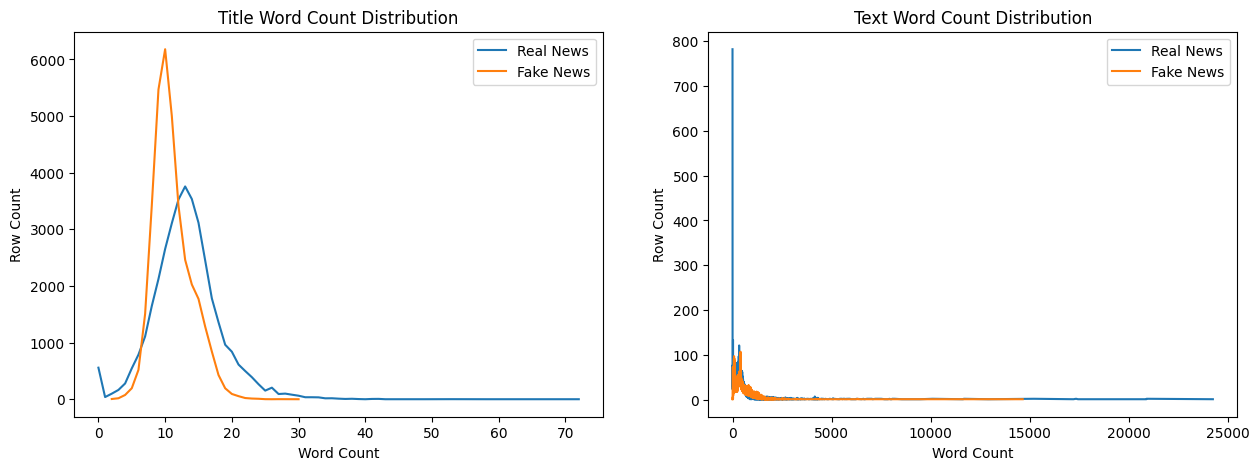

In [9]:
counted_fake_news = counted[counted['label'] == 0]
counted_real_news = counted[counted['label'] == 1]

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
counted_real_news['title-word-count'].value_counts().sort_index().plot(label = 'Real News', ax = ax[0])
counted_fake_news['title-word-count'].value_counts().sort_index().plot(label = 'Fake News', ax = ax[0])
counted_real_news['text-word-count'].value_counts().sort_index().plot(label = 'Real News', ax = ax[1])
counted_fake_news['text-word-count'].value_counts().sort_index().plot(label = 'Fake News', ax = ax[1])
ax[0].set_title('Title Word Count Distribution')
ax[1].set_title('Text Word Count Distribution')
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Word Count')
ax[0].set_ylabel('Row Count')
ax[1].set_ylabel('Row Count')
ax[0].legend()
ax[1].legend()
plt.show()

Можем да видим, че истинските новини могат да имат както много по-дълги заглавия, така и текстове. При заглавията, фалшивите новини имат по-голямо струпване в диапазона 10-13 думи. От друга страна, истинските новини имат доста текстове с много малко думи, което е учудващо, дори като вземем предвид празните текстове.

#### Процент на думи само с главни букви

In [3]:
def percent_all_caps(x: str) -> float:
    words = x.split()
    if len(words) == 0: return 0

    count = 0
    for w in words:
        if w.isupper():
            count += 1
    return count / len(words)

caps = data.copy()
caps['title'].fillna('', inplace = True)
caps['text'].fillna('', inplace = True)
caps['title-all-caps'] = caps['title'].apply(percent_all_caps)
caps['text-all-caps'] = caps['text'].apply(percent_all_caps)
caps.describe()

,label,title-all-caps,text-all-caps
count,72134.000000,72134.000000,72134.000000
mean,0.514404,0.098272,0.021809
std,0.499796,0.160420,0.039535
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.007874
50%,1.000000,0.000000,0.014815
75%,1.000000,0.130435,0.025424
max,1.000000,1.000000,1.000000


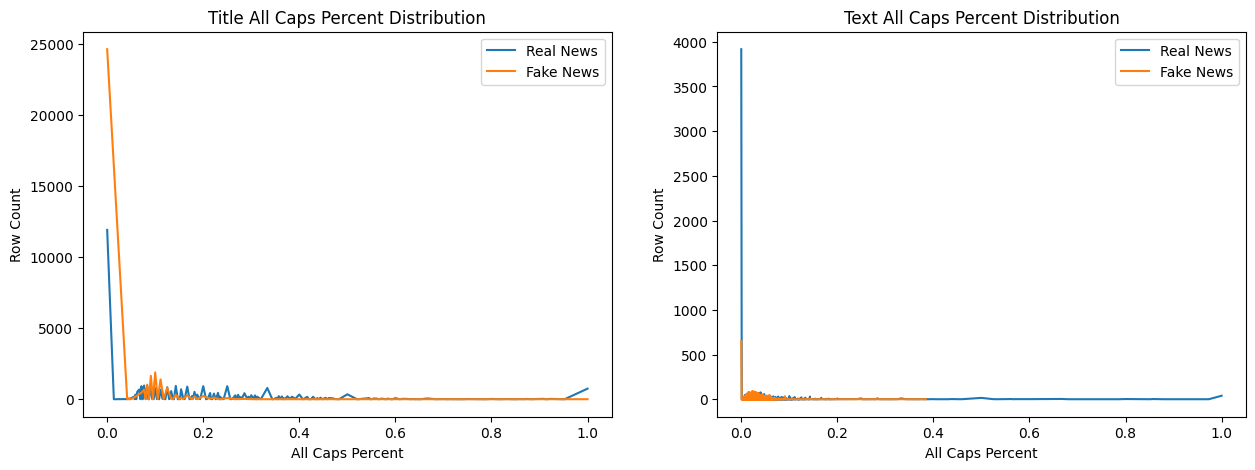

In [4]:
caps_fake_news = caps[caps['label'] == 0]
caps_real_news = caps[caps['label'] == 1]

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
caps_real_news['title-all-caps'].value_counts().sort_index().plot(label = 'Real News', ax = ax[0])
caps_fake_news['title-all-caps'].value_counts().sort_index().plot(label = 'Fake News', ax = ax[0])
caps_real_news['text-all-caps'].value_counts().sort_index().plot(label = 'Real News', ax = ax[1])
caps_fake_news['text-all-caps'].value_counts().sort_index().plot(label = 'Fake News', ax = ax[1])
ax[0].set_title('Title All Caps Percent Distribution')
ax[1].set_title('Text All Caps Percent Distribution')
ax[0].set_xlabel('All Caps Percent')
ax[1].set_xlabel('All Caps Percent')
ax[0].set_ylabel('Row Count')
ax[1].set_ylabel('Row Count')
ax[0].legend()
ax[1].legend()
plt.show()

Тук дистрибутицята и на истинските, и на фалшивите новини е предвидима - или много малко думи или почти всички са изцяло с главни букви. Като че ли при заглавията, истинските новини по-често са с главни букви. Няма особени заключения, които да могат да се направят тук.

### Трениране

In [27]:
X = data.drop('label', axis=1) 
y = data['label']